In [38]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F


In [39]:
df_weather = pd.read_csv('weather_pca_data.csv')

In [40]:
df_train = pd.read_csv('for_students/waiting_times_train.csv')
wait_time_in2h = df_train['WAIT_TIME_IN_2H'].apply(lambda x: int(x/5))
df_train

,DATETIME,ENTITY_DESCRIPTION_SHORT,ADJUST_CAPACITY,DOWNTIME,CURRENT_WAIT_TIME,TIME_TO_PARADE_1,TIME_TO_PARADE_2,TIME_TO_NIGHT_SHOW,WAIT_TIME_IN_2H
0,2022-02-05 11:45:00,Water Ride,247.00,0,20,NaN,NaN,NaN,30.0
1,2019-02-24 10:45:00,Water Ride,247.00,0,30,375.0,NaN,495.0,25.0
2,2021-07-17 15:45:00,Pirate Ship,280.50,0,35,NaN,NaN,NaN,35.0
3,2022-04-03 19:45:00,Pirate Ship,230.35,0,15,-135.0,NaN,195.0,10.0
4,2021-10-20 10:30:00,Pirate Ship,153.00,0,15,NaN,NaN,NaN,10.0
...,...,...,...,...,...,...,...,...,...
37013,2022-05-12 15:30:00,Flying Coaster,756.00,0,30,120.0,NaN,450.0,10.0
37014,2018-10-17 13:15:00,Pirate Ship,280.50,0,15,255.0,-65.0,405.0,20.0
37015,2018-12-27 19:45:00,Flying Coaster,756.00,0,15,-165.0,-475.0,135.0,10.0
37016,2020-02-16 13:00:00,Flying Coaster,756.00,0,30,240.0,NaN,420.0,45.0


In [41]:
MAX_VALUES = df_train.max()
MIN_VALUES = df_train.min()
factor = +1
df_train["TIME_TO_PARADE_1"]   = df_train["TIME_TO_PARADE_1"].fillna(factor*MIN_VALUES["TIME_TO_PARADE_1"])
df_train["TIME_TO_PARADE_2"]   = df_train["TIME_TO_PARADE_2"].fillna(factor*MIN_VALUES["TIME_TO_PARADE_2"])
df_train["TIME_TO_NIGHT_SHOW"] = df_train["TIME_TO_NIGHT_SHOW"].fillna(factor*MIN_VALUES["TIME_TO_NIGHT_SHOW"])

In [42]:
print(df_train['TIME_TO_PARADE_1'].isna().any())
print(df_train['TIME_TO_PARADE_2'].isna().any())
print(df_train['TIME_TO_NIGHT_SHOW'].isna().any())

False
False
False


In [43]:
dates = df_train["DATETIME"]
df_train.drop(["DATETIME", "ENTITY_DESCRIPTION_SHORT", "WAIT_TIME_IN_2H"], axis=1, inplace=True)

df_train=(df_train-df_train.mean())/df_train.std()
df_train["DATETIME"] = dates
df_train

,ADJUST_CAPACITY,DOWNTIME,CURRENT_WAIT_TIME,TIME_TO_PARADE_1,TIME_TO_PARADE_2,TIME_TO_NIGHT_SHOW,DATETIME
0,-0.660639,-0.168584,-0.240147,-1.152579,-0.410995,-1.117497,2022-02-05 11:45:00
1,-0.660639,-0.168584,0.468341,1.280950,-0.410995,0.893157,2019-02-24 10:45:00
2,-0.527907,-0.168584,0.822585,-1.152579,-0.410995,-1.117497,2021-07-17 15:45:00
3,-0.726608,-0.168584,-0.594390,-0.170629,-0.410995,-0.020777,2022-04-03 19:45:00
4,-1.033079,-0.168584,-0.594390,-1.152579,-0.410995,-1.117497,2021-10-20 10:30:00
...,...,...,...,...,...,...,...
37013,1.356085,-0.168584,0.468341,0.555161,-0.410995,0.756067,2022-05-12 15:30:00
37014,-0.527907,-0.168584,-0.594390,0.939402,2.420117,0.618977,2018-10-17 13:15:00
37015,1.356085,-0.168584,-0.594390,-0.256016,0.230012,-0.203564,2018-12-27 19:45:00
37016,1.356085,-0.168584,0.468341,0.896709,-0.410995,0.664673,2020-02-16 13:00:00


In [44]:
df_combined = pd.merge(df_train, df_weather, on='DATETIME', how='left')
df_combined

,ADJUST_CAPACITY,DOWNTIME,CURRENT_WAIT_TIME,TIME_TO_PARADE_1,TIME_TO_PARADE_2,TIME_TO_NIGHT_SHOW,DATETIME,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.660639,-0.168584,-0.240147,-1.152579,-0.410995,-1.117497,2022-02-05 11:45:00,-1.703404,-0.561189,-0.521895,0.099553,0.564666,0.303006
1,-0.660639,-0.168584,0.468341,1.280950,-0.410995,0.893157,2019-02-24 10:45:00,-0.983224,-3.370968,1.688497,0.822912,-0.257597,1.030229
2,-0.527907,-0.168584,0.822585,-1.152579,-0.410995,-1.117497,2021-07-17 15:45:00,1.971007,0.491093,-0.446060,-1.375623,0.711029,0.848786
3,-0.726608,-0.168584,-0.594390,-0.170629,-0.410995,-0.020777,2022-04-03 19:45:00,-1.153047,-1.460163,0.761943,0.267117,-0.799023,1.794617
4,-1.033079,-0.168584,-0.594390,-1.152579,-0.410995,-1.117497,2021-10-20 10:30:00,0.644351,2.261365,0.670276,0.539488,0.961583,0.083199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37013,1.356085,-0.168584,0.468341,0.555161,-0.410995,0.756067,2022-05-12 15:30:00,2.474459,-0.242590,-1.250092,0.433454,-2.257249,1.038954
37014,-0.527907,-0.168584,-0.594390,0.939402,2.420117,0.618977,2018-10-17 13:15:00,1.451294,-0.740837,-0.309993,-0.850829,1.254196,-0.054063
37015,1.356085,-0.168584,-0.594390,-0.256016,0.230012,-0.203564,2018-12-27 19:45:00,-3.211167,-0.929818,-1.205296,-0.270431,0.000201,0.500882
37016,1.356085,-0.168584,0.468341,0.896709,-0.410995,0.664673,2020-02-16 13:00:00,0.588498,2.259265,2.034889,-0.714293,-0.254688,0.621635


In [45]:
date_time = df_train["DATETIME"]

def convert_date(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    jour_semaine = date_obj.strftime('%A')  # Jour de la semaine (nom complet)
    mois = date_obj.strftime('%B')  # Mois (nom complet)
    annee = date_obj.year  # Année
    return [jour_semaine, mois, annee]

times = []
years = []
months = []
days_week = []

for date in date_time:
    day, month, year = convert_date(date[:10])
    years.append(year)
    months.append(month)
    days_week.append(day)
    time = date[11:16]
    times.append(int(time[:2]) * 4 + int(time[3:5]) // 15)

times = np.array(times) - np.min(times)

encoded_years = pd.get_dummies(years)
encoded_months = pd.get_dummies(months)
encoded_days_week = pd.get_dummies(days_week)
encoded_times = pd.get_dummies(times)

print(encoded_days_week)
print(encoded_times)
print(encoded_years)
print(encoded_months)

       Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
0       False   False      True   False     False    False      False
1       False   False     False    True     False    False      False
2       False   False      True   False     False    False      False
3       False   False     False    True     False    False      False
4       False   False     False   False     False    False       True
...       ...     ...       ...     ...       ...      ...        ...
37013   False   False     False   False      True    False      False
37014   False   False     False   False     False    False       True
37015   False   False     False   False      True    False      False
37016   False   False     False    True     False    False      False
37017    True   False     False   False     False    False      False

[37018 rows x 7 columns]
          0      1      2      3      4      5      6      7      8      9   \
0      False  False  False  False  False  False  False 

In [46]:
df_combined = pd.concat([df_combined, encoded_years, encoded_months, encoded_days_week, encoded_times, wait_time_in2h], axis=1)
df_combined.drop(["DATETIME"], axis=1, inplace=True)
df_combined

,ADJUST_CAPACITY,DOWNTIME,CURRENT_WAIT_TIME,TIME_TO_PARADE_1,TIME_TO_PARADE_2,TIME_TO_NIGHT_SHOW,PC1,PC2,PC3,PC4,...,39,40,41,42,43,44,45,46,47,WAIT_TIME_IN_2H
0,-0.660639,-0.168584,-0.240147,-1.152579,-0.410995,-1.117497,-1.703404,-0.561189,-0.521895,0.099553,...,False,False,False,False,False,False,False,False,False,6
1,-0.660639,-0.168584,0.468341,1.280950,-0.410995,0.893157,-0.983224,-3.370968,1.688497,0.822912,...,False,False,False,False,False,False,False,False,False,5
2,-0.527907,-0.168584,0.822585,-1.152579,-0.410995,-1.117497,1.971007,0.491093,-0.446060,-1.375623,...,False,False,False,False,False,False,False,False,False,7
3,-0.726608,-0.168584,-0.594390,-0.170629,-0.410995,-0.020777,-1.153047,-1.460163,0.761943,0.267117,...,False,False,False,False,True,False,False,False,False,2
4,-1.033079,-0.168584,-0.594390,-1.152579,-0.410995,-1.117497,0.644351,2.261365,0.670276,0.539488,...,False,False,False,False,False,False,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37013,1.356085,-0.168584,0.468341,0.555161,-0.410995,0.756067,2.474459,-0.242590,-1.250092,0.433454,...,False,False,False,False,False,False,False,False,False,2
37014,-0.527907,-0.168584,-0.594390,0.939402,2.420117,0.618977,1.451294,-0.740837,-0.309993,-0.850829,...,False,False,False,False,False,False,False,False,False,4
37015,1.356085,-0.168584,-0.594390,-0.256016,0.230012,-0.203564,-3.211167,-0.929818,-1.205296,-0.270431,...,False,False,False,False,True,False,False,False,False,2
37016,1.356085,-0.168584,0.468341,0.896709,-0.410995,0.664673,0.588498,2.259265,2.034889,-0.714293,...,False,False,False,False,False,False,False,False,False,9


In [47]:
# to csv
df_combined.to_csv('processed_waiting_times_train.csv', index=False)

In [ ]:
def convert_date(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    jour_semaine = date_obj.strftime('%A')  # Jour de la semaine (nom complet)
    mois = date_obj.strftime('%B')  # Mois (nom complet)
    annee = date_obj.year  # Année
    return [jour_semaine, mois, annee]

def process_dataframe(df):
    # wait_time_in2h = df_train['WAIT_TIME_IN_2H'].apply(lambda x: int(x/5))
    max_values = df.max()
    NB_MAX = 5
    df["TIME_TO_PARADE_1"]   = df["TIME_TO_PARADE_1"].fillna(NB_MAX*max_values["TIME_TO_PARADE_1"])
    df["TIME_TO_PARADE_2"]   = df["TIME_TO_PARADE_2"].fillna(NB_MAX*max_values["TIME_TO_PARADE_2"])
    df["TIME_TO_NIGHT_SHOW"] = df["TIME_TO_NIGHT_SHOW"].fillna(NB_MAX*max_values["TIME_TO_NIGHT_SHOW"])
    
    dates = df["DATETIME"]
    # , "WAIT_TIME_IN_2H"
    df.drop(["DATETIME", "ENTITY_DESCRIPTION_SHORT"], axis=1, inplace=True)

    df=(df-df.mean())/df.std()
    df["DATETIME"] = dates

    df_combined = pd.merge(df_train, df_weather, on='DATETIME', how='left')

    date_time = df["DATETIME"]

    times = []
    years = []
    months = []
    days_week = []

    for date in date_time:
        day, month, year = convert_date(date[:10])
        years.append(year)
        months.append(month)
        days_week.append(day)
        time = date[11:16]
        times.append(int(time[:2]) * 4 + int(time[3:5]) // 15)

    times = np.array(times) - np.min(times)

    encoded_years = pd.get_dummies(years)
    encoded_months = pd.get_dummies(months)
    encoded_days_week = pd.get_dummies(days_week)
    encoded_times = pd.get_dummies(times)

    df_combined = pd.concat([df_combined, encoded_years, encoded_months, encoded_days_week, encoded_times], axis=1)
    df_combined.drop(["DATETIME"], axis=1, inplace=True)

    return df_combined

In [ ]:
df_val = pd.read_csv('for_students/waiting_times_X_test_val.csv')

print(MIN_VALUES)
df_val["TIME_TO_PARADE_1"]   = df_val["TIME_TO_PARADE_1"].fillna(factor*MIN_VALUES["TIME_TO_PARADE_1"])
df_val["TIME_TO_PARADE_2"]   = df_val["TIME_TO_PARADE_2"].fillna(factor*MIN_VALUES["TIME_TO_PARADE_2"])
df_val["TIME_TO_NIGHT_SHOW"] = df_val["TIME_TO_NIGHT_SHOW"].fillna(factor*MIN_VALUES["TIME_TO_NIGHT_SHOW"])

dates = df_val["DATETIME"]
entities = df_val["ENTITY_DESCRIPTION_SHORT"]
df_val.drop(["DATETIME", "ENTITY_DESCRIPTION_SHORT"], axis=1, inplace=True)

df_val=(df_val-df_val.mean())/df_val.std()
df_val["DATETIME"] = dates

df_val_combined = pd.merge(df_val, df_weather, on='DATETIME', how='left')

date_time = df_val_combined["DATETIME"]

times = []
years = []
months = []
days_week = []

for date in date_time:
    day, month, year = convert_date(date[:10])
    years.append(year)
    months.append(month)
    days_week.append(day)
    time = date[11:16]
    times.append(int(time[:2]) * 4 + int(time[3:5]) // 15)

times = np.array(times) - np.min(times)

encoded_years = pd.get_dummies(years)
encoded_months = pd.get_dummies(months)
encoded_days_week = pd.get_dummies(days_week)
encoded_times = pd.get_dummies(times)

df_val_combined = pd.concat([df_val_combined, encoded_years, encoded_months, encoded_days_week, encoded_times, entities], axis=1)


df_val_combined

DATETIME                    2022-08-16 18:45:00
ENTITY_DESCRIPTION_SHORT             Water Ride
ADJUST_CAPACITY                           756.0
DOWNTIME                                     14
CURRENT_WAIT_TIME                           155
TIME_TO_PARADE_1                          570.0
TIME_TO_PARADE_2                          235.0
TIME_TO_NIGHT_SHOW                        840.0
WAIT_TIME_IN_2H                           155.0
dtype: object


,ADJUST_CAPACITY,DOWNTIME,CURRENT_WAIT_TIME,TIME_TO_PARADE_1,TIME_TO_PARADE_2,TIME_TO_NIGHT_SHOW,DATETIME,PC1,PC2,PC3,...,39,40,41,42,43,44,45,46,47,ENTITY_DESCRIPTION_SHORT
0,-0.640132,-0.149953,-0.366211,-0.734014,-2.005533,-0.757623,2019-11-23 10:45:00,-0.723665,3.844662,0.243095,...,False,False,False,False,False,False,False,False,False,Water Ride
1,-1.018377,-0.149953,1.415277,1.118014,0.401814,1.120504,2022-01-03 16:45:00,-0.451292,2.017454,0.058099,...,False,False,False,False,False,False,False,False,False,Pirate Ship
2,-0.607941,-0.149953,1.058979,1.118014,0.401814,1.120504,2021-12-04 15:30:00,-1.309027,1.426940,0.922631,...,False,False,False,False,False,False,False,False,False,Pirate Ship
3,-0.640132,-0.149953,-0.722508,-0.846258,0.401814,-0.933448,2020-02-05 13:15:00,-0.871256,-1.400221,-1.044924,...,False,False,False,False,False,False,False,False,False,Water Ride
4,1.408022,-0.149953,0.702682,-0.913604,0.401814,-0.869512,2022-05-13 15:15:00,2.677412,-1.899325,-0.008500,...,False,False,False,False,False,False,False,False,False,Flying Coaster
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439,-0.640132,-0.149953,0.346384,-0.891156,-2.465117,-0.885496,2019-10-29 14:45:00,-0.326194,0.042633,-0.088452,...,False,False,False,False,False,False,False,False,False,Water Ride
2440,-0.640132,-0.149953,-0.722508,-0.969727,-2.694909,-1.005376,2019-10-08 16:30:00,0.611443,1.630446,-1.367938,...,False,False,False,False,False,False,False,False,False,Water Ride
2441,-0.640132,-0.149953,-0.366211,-0.902380,0.401814,-0.861520,2022-04-09 15:00:00,-0.025587,-0.741237,-0.984157,...,False,False,False,False,False,False,False,False,False,Water Ride
2442,1.408022,-0.149953,0.346384,-0.913604,0.401814,-0.869512,2022-06-16 15:15:00,4.050900,-1.375022,0.451623,...,False,False,False,False,False,False,False,False,False,Flying Coaster


In [ ]:
df_val_combined.to_csv('processed_waiting_times_val.csv', index=False)

(array([6.252e+03, 7.575e+03, 4.206e+03, 9.564e+03, 3.315e+03, 4.285e+03,
        8.720e+02, 6.820e+02, 3.900e+01, 1.550e+02, 4.900e+01, 2.200e+01,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.  ,   7.75,  15.5 ,  23.25,  31.  ,  38.75,  46.5 ,  54.25,
         62.  ,  69.75,  77.5 ,  85.25,  93.  , 100.75, 108.5 , 116.25,
        124.  , 131.75, 139.5 , 147.25, 155.  ]),
 <BarContainer object of 20 artists>)

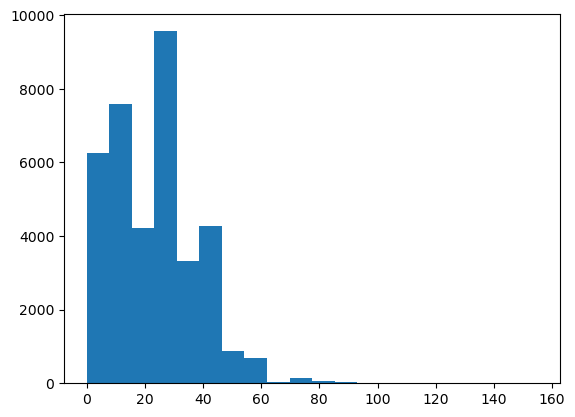

In [ ]:
import matplotlib.pyplot as plt
df = pd.read_csv('for_students/waiting_times_train.csv')
# breaks = 20
plt.hist(df["WAIT_TIME_IN_2H"], bins=20)